In [71]:
import os
import geopandas as gp
import shapely
import fiona
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile

extract_folder = 'C:\\Users\\oliver\\1161\\dateproject'
zip_file_name = "C:\\Users\\oliver\\1161\\dateproject\\date\\crashdate.zip"

In [72]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [73]:
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

extracted_file_path = os.path.join(extract_folder, 'crashdate.csv')
if os.path.exists(extracted_file_path):
    with open(extracted_file_path, 'r') as file:
        penalty_data = pd.read_csv(
            'C:\\Users\\oliver\\1161\\dateproject\\crashdate.csv')
        print("ok")
else:
    print("false")

ok


In [74]:
penalty_data.head(20)

,Crash_Ref_Number,Crash_Severity,Crash_Year,Crash_Month,Crash_Day_Of_Week,Crash_Hour,Crash_Nature,Crash_Type,Crash_Longitude,Crash_Latitude,...,Count_Casualty_MedicallyTreated,Count_Casualty_MinorInjury,Count_Casualty_Total,Count_Unit_Car,Count_Unit_Motorcycle_Moped,Count_Unit_Truck,Count_Unit_Bus,Count_Unit_Bicycle,Count_Unit_Pedestrian,Count_Unit_Other
0,1,Hospitalisation,2001,January,Monday,6,Head-on,Multi-Vehicle,153.052207,-27.586358,...,0,0,1,1,0,0,0,1,0,0
1,2,Property damage only,2001,January,Wednesday,9,Angle,Multi-Vehicle,153.064920,-27.595907,...,0,0,0,2,0,0,0,0,0,0
2,3,Minor injury,2001,January,Thursday,8,Rear-end,Multi-Vehicle,153.058444,-27.599409,...,0,1,1,2,0,0,0,0,0,0
3,4,Property damage only,2001,January,Sunday,8,Hit object,Single Vehicle,153.081083,-27.598882,...,0,0,0,1,0,0,0,0,0,0
4,5,Property damage only,2001,January,Tuesday,16,Overturned,Single Vehicle,0.000009,-0.000010,...,0,0,0,1,0,0,0,0,0,0
5,6,Property damage only,2001,January,Wednesday,9,Angle,Multi-Vehicle,153.015202,-27.566968,...,0,0,0,1,0,1,0,0,0,0
6,7,Property damage only,2001,January,Wednesday,17,Hit object,Single Vehicle,153.060738,-27.587870,...,0,0,0,1,0,0,0,0,0,0
7,8,Medical treatment,2001,January,Thursday,9,Hit pedestrian,Hit pedestrian,153.016442,-27.560409,...,1,0,1,0,0,1,0,0,1,0
8,9,Hospitalisation,2001,January,Sunday,15,Angle,Multi-Vehicle,153.065510,-27.602946,...,0,0,1,1,0,0,0,1,0,0
9,10,Property damage only,2001,January,Tuesday,15,Angle,Multi-Vehicle,153.020787,-27.572325,...,0,0,0,2,0,0,0,0,0,0


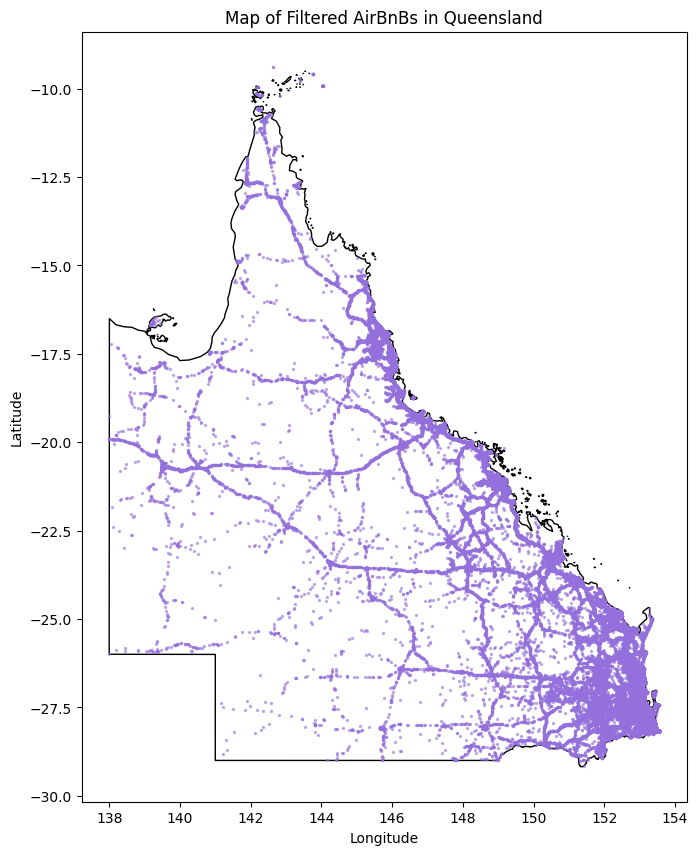

In [75]:
valid_longitude_range = (130, 160)
valid_latitude_range = (-30, 0)
filtered_data = penalty_data[
    (penalty_data['Crash_Longitude'] >= valid_longitude_range[0]) &
    (penalty_data['Crash_Longitude'] <= valid_longitude_range[1]) &
    (penalty_data['Crash_Latitude'] >= valid_latitude_range[0]) &
    (penalty_data['Crash_Latitude'] <= valid_latitude_range[1])
]
queensland = gp.read_file(
    'C:\\Users\\oliver\\1161\\dateproject\\date\\queensland.json')
filtered_points = gp.GeoDataFrame(geometry=gp.points_from_xy(
    filtered_data['Crash_Longitude'], filtered_data['Crash_Latitude']))
fig, axs = plt.subplots(figsize=(20, 10))
queensland.boundary.plot(ax=axs, color='black', linewidth=1)
filtered_points.plot(ax=axs, marker='o', markersize=2,
                     alpha=0.5, color='mediumpurple', zorder=2)
axs.set_title('Map of Filtered AirBnBs in Queensland')
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')
plt.show()

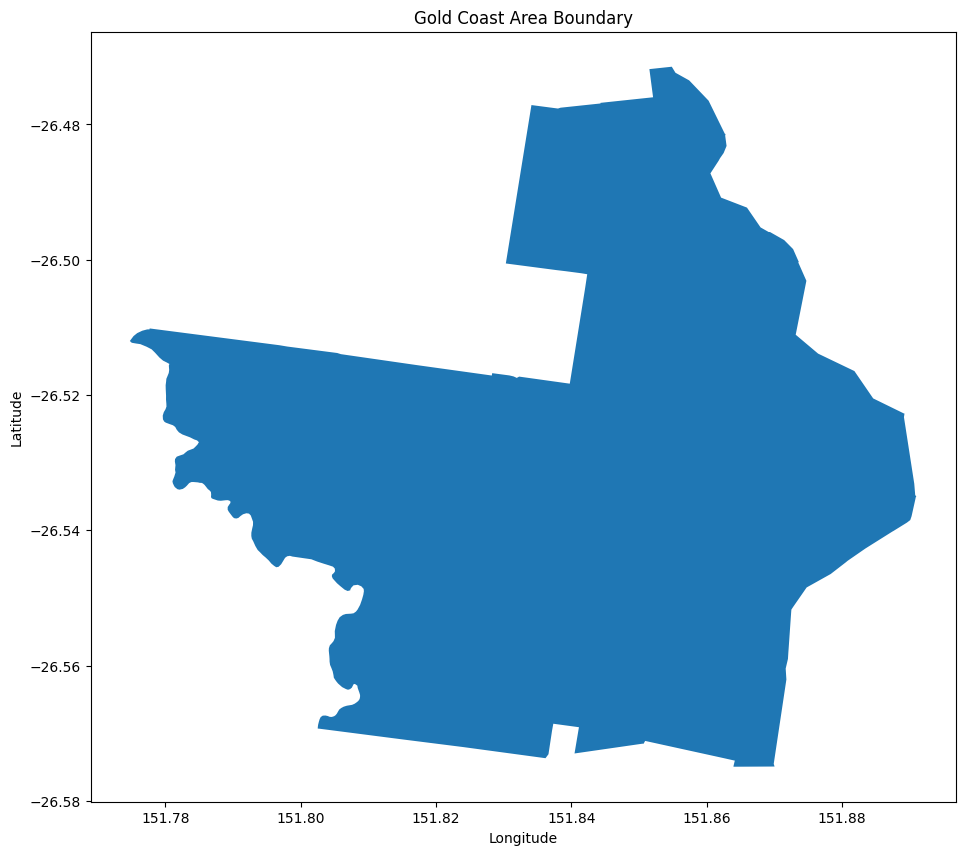

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry
0,lcp1538f231f6a1,locb9e60560b913,2021-06-24,Abbeywood,Gazetted Locality,QLD,"POLYGON ((151.638 -26.146, 151.637 -26.146, 15..."
1,lcp5c0cb0eb8528,locda24ebdbfa94,2021-06-24,Abbotsford,Gazetted Locality,QLD,"POLYGON ((152.004 -24.883, 151.999 -24.879, 15..."
2,lcp1f44628e7c62,loc58529273d380,2021-06-24,Abercorn,Gazetted Locality,QLD,"POLYGON ((151.136 -25.178, 151.135 -25.177, 15..."
3,lcp4bddfa663b0c,loc3c258d5cae53,2021-06-24,Abergowrie,Gazetted Locality,QLD,"POLYGON ((145.998 -18.513, 145.995 -18.513, 14..."
4,lcp191e01d5506a,locf1eb9c4b0e48,2021-06-24,Abingdon Downs,Gazetted Locality,QLD,"POLYGON ((143.763 -18.110, 143.595 -18.094, 14..."
5,lcpec85fef8a167,loc0ca81bdf7282,2021-06-24,Abington,Gazetted Locality,QLD,"POLYGON ((152.370 -25.231, 152.369 -25.231, 15..."
6,lcpeb1b134367c4,loc086288c9d338,2021-06-24,Acacia Ridge,Gazetted Locality,QLD,"POLYGON ((153.040 -27.599, 153.039 -27.599, 15..."
7,lcp2539bc2fa8da,loc8978ca8de825,2021-06-24,Acland,Gazetted Locality,QLD,"POLYGON ((151.711 -27.343, 151.711 -27.343, 15..."
8,lcp0cfd0e921ef4,locd30d7dfae4c2,2021-06-24,Adare,Gazetted Locality,QLD,"POLYGON ((152.311 -27.546, 152.311 -27.545, 15..."
9,lcp6b4328fa372d,loc790fa55d1c0a,2021-12-03,Adavale,Gazetted Locality,QLD,"POLYGON ((144.959 -27.185, 144.867 -27.176, 14..."


In [76]:
burbs = gp.GeoDataFrame.from_file(
    'C:\\Users\\oliver\\1161\\dateproject\\date\\GDA2020\\qld_localities.shp')
burbs.set_crs(epsg=5234, inplace=True, allow_override=True)
gold_coast = burbs[burbs['LOC_NAME'].str.contains('Kingaroy', case=False)]
gold_coast.plot()
plt.title('Gold Coast Area Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
burbs.head(10)

In [77]:
def add_centroid(row):
    return row.geometry.centroid


burbs["centroid"] = burbs.apply(add_centroid, axis=1)

burbs.sample(2)

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry,centroid
1045,lcp982502ce0df9,loc14fc0385138e,2021-06-24,Ficks Crossing,Gazetted Locality,QLD,"POLYGON ((151.899 -26.286, 151.899 -26.286, 15...",POINT (151.89051 -26.26206)
361,lcpnzcRZOrykKCp,loc72c51ee50561,2023-03-21,Braemeadows,Gazetted Locality,QLD,"POLYGON ((146.226 -18.692, 146.226 -18.691, 14...",POINT (146.26672 -18.64763)


<Axes: >

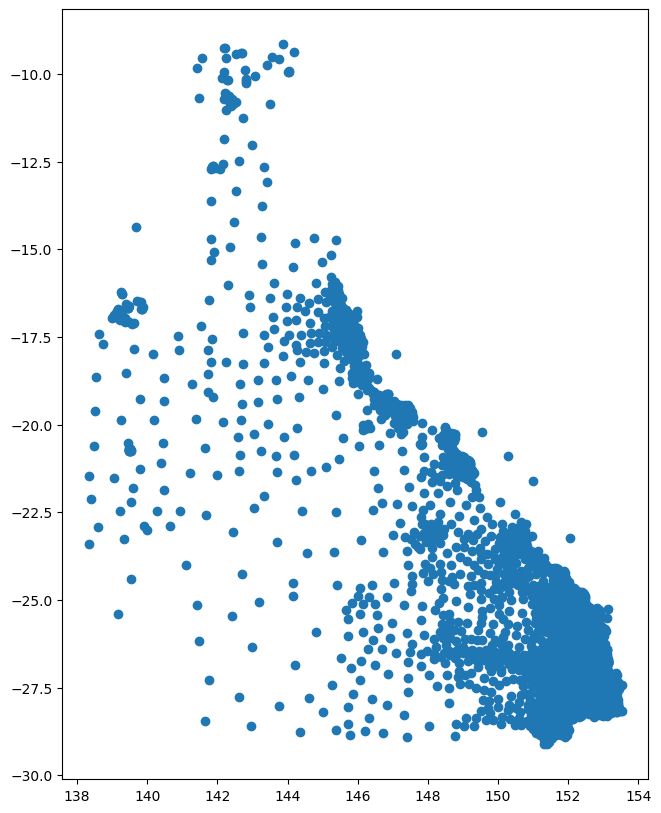

In [78]:
burbs.centroid.plot()

POINT (152.01080397169943 -24.830328047524123)


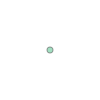

In [79]:
a = burbs.iloc[1]
print(a.centroid)
a.centroid

In [80]:
right_here = shapely.geometry.point.Point(151.390967,-26.659072)
burbs["distance_from_UNSW"] = burbs.centroid.distance(right_here)

Text(0.5, 1.0, 'Distribution of distances from UNSW')

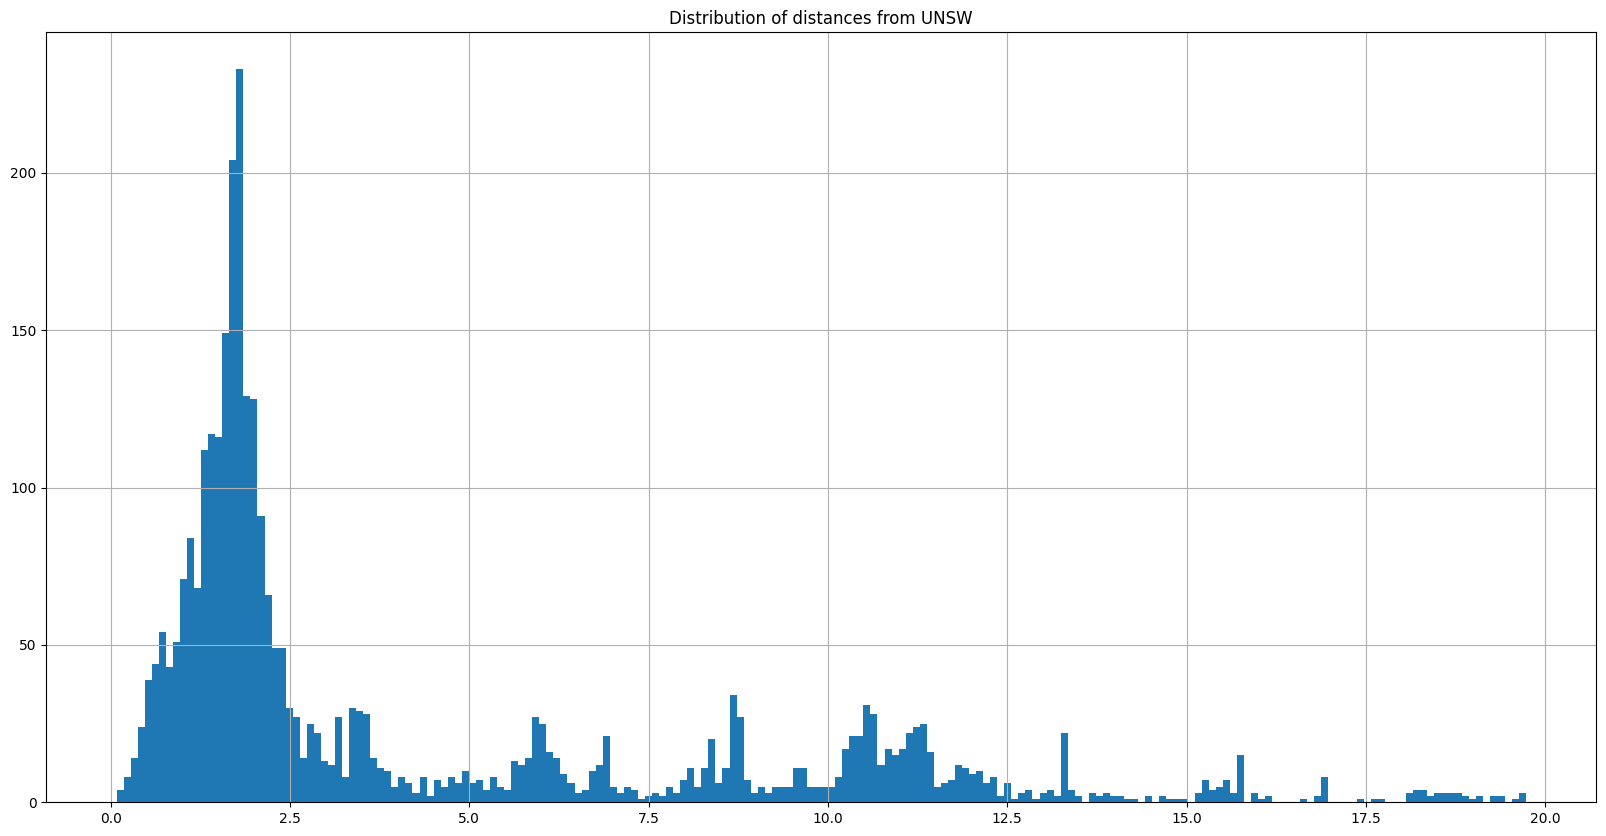

In [82]:
burbs.distance_from_UNSW.hist(bins=200)
plt.title("Distribution of distances from UNSW")

<Axes: >

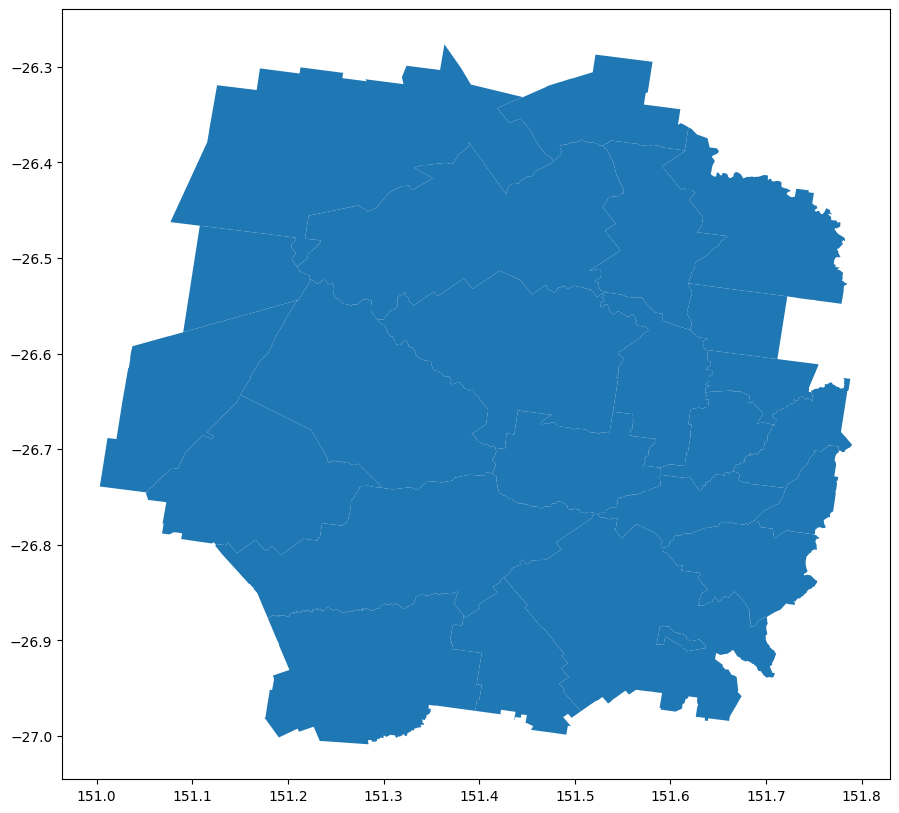

In [89]:
close_burbs = burbs[burbs.distance_from_UNSW < 0.37]
close_burbs.plot()

In [90]:
penalty_data = pd.read_csv('C:\\Users\\oliver\\1161\\dateproject\\crashdate.csv')

points = list(zip(penalty_data['Crash_Longitude'], penalty_data['Crash_Latitude']))
for point in points:
    pass

In [91]:
from shapely.geometry import Point, Polygon, MultiPolygon
polygon_column = 'geometry'
polygons = close_burbs[polygon_column]
polygonslist = [Polygon(coords) for coords in polygons]
multi_polygon = MultiPolygon(polygonslist)
points_inside_polygons = [
    point for point in points if multi_polygon.contains(Point(point))]


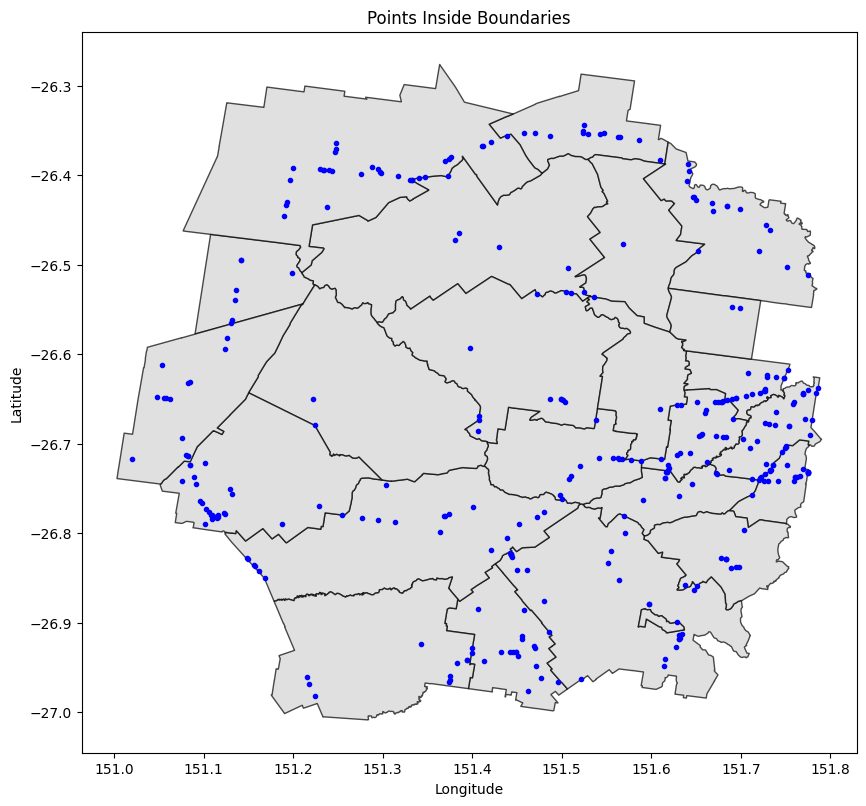

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))
close_burbs.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.7)
for point in points_inside_polygons:
    plt.plot(point[0], point[1], 'bo', markersize=3)
ax.set_title('Points Inside Boundaries')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

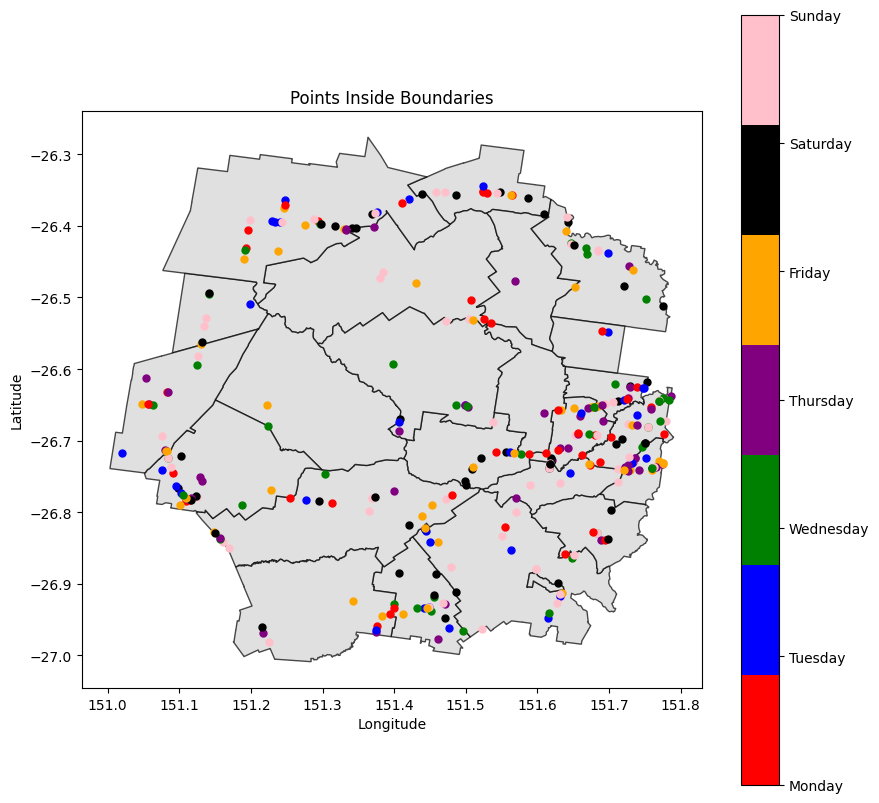

In [95]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
from matplotlib.colors import ListedColormap
import numpy as np

# 读取 crashdate.csv 文件
penalty_data = pd.read_csv('C:\\Users\\oliver\\1161\\dateproject\\crashdate.csv')

# 提取经纬度数据和 Crash_Day_Of_Week 标签列
points = list(zip(penalty_data['Crash_Longitude'], penalty_data['Crash_Latitude']))
crash_day_of_week_labels = penalty_data['Crash_Day_Of_Week']

# 将 Crash_Day_Of_Week 类别映射为数字标签
day_of_week_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
crash_day_of_week_numeric = [day_of_week_mapping[label] for label in crash_day_of_week_labels]

# 设置颜色列表
colors = ['red', 'blue', 'green', 'purple', 'orange', 'black', 'pink']
cmap = ListedColormap(colors)

# 创建一个虚拟的映射对象，用于颜色条
norm = plt.Normalize(vmin=0, vmax=len(day_of_week_mapping)-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # 设置一个空的数组作为映射数据

# 提取多边形数据（假设已有 close_burbs GeoDataFrame）
polygon_column = 'geometry'
polygons = close_burbs[polygon_column]

# 创建多边形对象列表
polygonslist = [Polygon(coords) for coords in polygons]

# 创建 MultiPolygon 对象
multi_polygon = MultiPolygon(polygonslist)

# 筛选在多边形内的点坐标和对应的 Crash_Day_Of_Week 数字标签
points_inside_polygons = [
    (point, day) for point, day in zip(points, crash_day_of_week_numeric) if multi_polygon.contains(Point(point))
]

# 可视化展示
fig, ax = plt.subplots(figsize=(10, 10))

# 绘制多边形边界
close_burbs.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.7)

# 绘制筛选出的点，并根据 Crash_Day_Of_Week 数字标签值确定颜色
for point, day in points_inside_polygons:
    plt.plot(point[0], point[1], 'o', color=sm.to_rgba(day), markersize=5)

# 添加颜色条
cbar = plt.colorbar(sm, ax=ax, ticks=range(len(day_of_week_mapping)))
cbar.set_ticklabels(day_of_week_mapping.keys())

# 设置图形标题和坐标轴标签
ax.set_title('Points Inside Boundaries')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# 显示图形
plt.show()

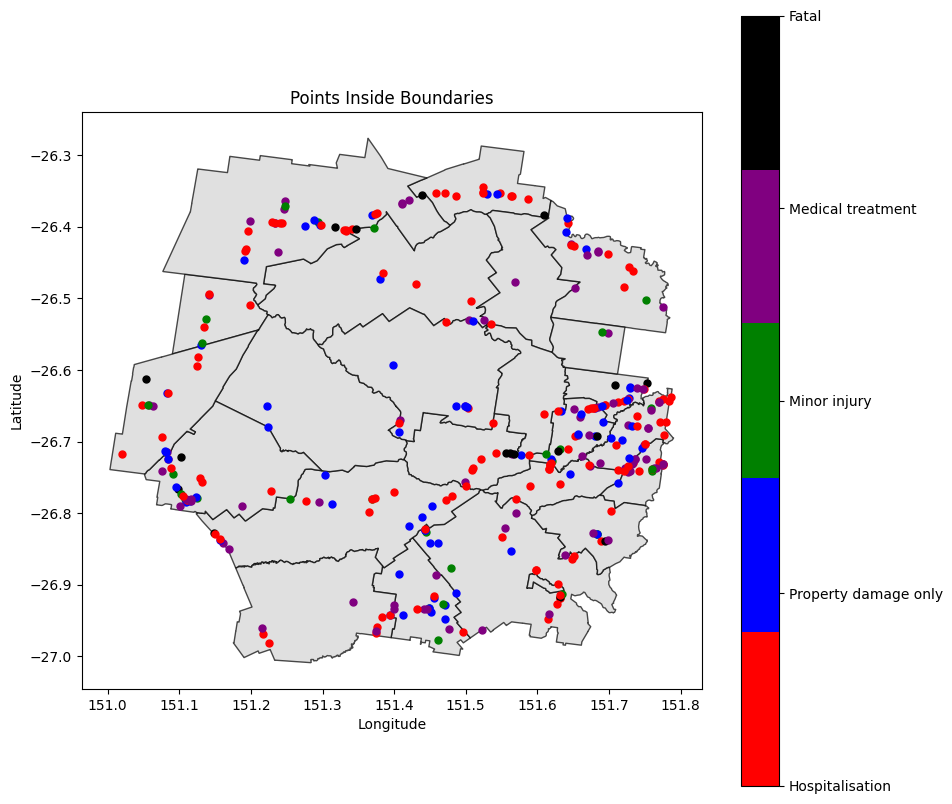

In [94]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
from matplotlib.colors import ListedColormap
import numpy as np

# 读取 crashdate.csv 文件
penalty_data = pd.read_csv('C:\\Users\\oliver\\1161\\dateproject\\crashdate.csv')

# 提取经纬度数据和 Crash_Severity 标签列
points = list(zip(penalty_data['Crash_Longitude'], penalty_data['Crash_Latitude']))
crash_severity_labels = penalty_data['Crash_Severity']

# 将 Crash_Severity 类别映射为数字标签
severity_labels = ['Hospitalisation', 'Property damage only', 'Minor injury', 'Medical treatment', 'Fatal']
severity_mapping = {label: index for index, label in enumerate(severity_labels)}
crash_severity_numeric = [severity_mapping[label] for label in crash_severity_labels]
colors = ['red', 'blue', 'green', 'purple', 'black']
cmap = ListedColormap(colors)

# 创建一个虚拟的映射对象，用于颜色条
norm = plt.Normalize(vmin=0, vmax=len(severity_labels)-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # 设置一个空的数组作为映射数据

# 提取多边形数据（假设已有 close_burbs GeoDataFrame）
polygon_column = 'geometry'
polygons = close_burbs[polygon_column]

# 创建多边形对象列表
polygonslist = [Polygon(coords) for coords in polygons]

# 创建 MultiPolygon 对象
multi_polygon = MultiPolygon(polygonslist)

# 筛选在多边形内的点坐标和对应的 Crash_Severity 数字标签
points_inside_polygons = [
    (point, severity) for point, severity in zip(points, crash_severity_numeric) if multi_polygon.contains(Point(point))
]

# 可视化展示
fig, ax = plt.subplots(figsize=(10, 10))

# 绘制多边形边界
close_burbs.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.7)

# 绘制筛选出的点，并根据 Crash_Severity 数字标签值确定颜色
for point, severity in points_inside_polygons:
    plt.plot(point[0], point[1], 'o', color=sm.to_rgba(severity), markersize=5)

# 添加颜色条
cbar = plt.colorbar(sm, ax=ax, ticks=range(len(severity_labels)))
cbar.set_ticklabels(severity_labels)

# 设置图形标题和坐标轴标签
ax.set_title('Points Inside Boundaries')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# 显示图形
plt.show()